In [6]:
### ATOC5860 - seasonal_cycle_filtering_FFT
### Originally from Libby Barnes (Colorado State University)
### Additional commenting/code from Jennifer Kay (University of Colorado)
### Last updated March 29, 2022

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio

In [7]:
### Read in the data - daily mean sea level pressure from ERA-Interim at 33 N, 170 E
### January 1, 1979 through December 31, 2012
DATA = sio.loadmat('mslp_erainterim_daily_33N_170E.mat')
X = DATA['Xin']
TIME = DATA['TIME']

print(np.shape(X))
print(np.shape(TIME))
#print(TIME[12418,:])

(12419, 1)
(12419, 4)


(366, 2)


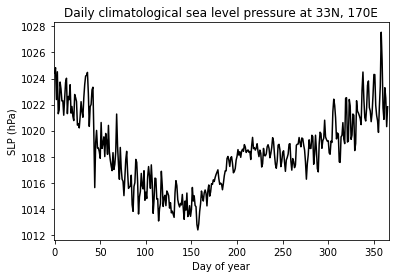

In [8]:
### Calculate the daily climatology (i.e., average each day over all years)
foo = {tuple(row) for row in TIME[:,2:4]}
TIME_climate = np.vstack(tuple(foo))
print(TIME_climate.shape)
TIME_climate = TIME_climate[np.lexsort((TIME_climate[:,1],TIME_climate[:,0])),:]
#print(TIME_climate)
days_in_year = np.size(TIME_climate, axis=0)
Yclim = np.empty(days_in_year)
Yclim[:] = np.NAN
for iday in np.arange(0,days_in_year):
    month = TIME_climate[iday,0]
    day = TIME_climate[iday,1]
    t = np.where(np.logical_and(TIME[:,2]==month,TIME[:,3]==day))
    Yclim[iday] = np.nanmean(X[t])   
    
### Plot the mean seasonal cycle (i.e., the values of the daily climatology over an entire year)
plt.plot(np.arange(0,np.size(Yclim)),Yclim,'-k');
plt.ylabel('SLP (hPa)');
plt.xlabel('Day of year');
plt.xlim(-1,366);
plt.title('Daily climatological sea level pressure at 33N, 170E'); 

In [9]:
### Calculate the seasonal cycle anomaly (i.e., remove the annual mean) for the FFT
### and PLOT IT.
#X = Yclim  ## Look at what happens when you do not remove the mean :).  Doesn't work very well.. 

X = Yclim - np.mean(Yclim);
#plt.plot(np.arange(0,np.size(X)),X,'-k');
#plt.ylabel('SLP anomaly (hPa)');
#plt.xlabel('Day of year');
#plt.xlim(-1,366);
#plt.title('Seasonal cycle of climatological sea level pressure anomaly at 33N, 170E');

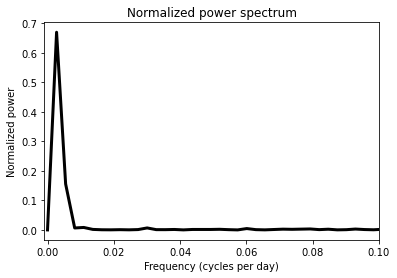

In [10]:
### Calculate the FFT of the data (X) using numpy
Z = np.fft.fft(X)
## Note: to get the right variance, need to normalize by the length of the time series
Yfft = Z/np.size(X);

## however, don't want to normalize if inputting back into "ifft"

### Plot the out FFT power
#plt.plot(np.arange(0,np.size(Yfft)),np.abs(Yfft)**2);
#plt.plot(0,np.abs(Yfft[0])**2.,'sg',markersize=10);
#plt.plot(1,np.abs(Yfft[1])**2.,'*r',markersize=20);
#plt.plot(np.size(Yfft)-1,np.abs(Yfft[-1])**2.,'*r',markersize=20);
#plt.xlabel('index');
#plt.ylabel('$C_k^2$ (power)');
#plt.title('Python numpy FFT output');
#plt.ylim(-.5,4)
#plt.xlim(-5,365+5)

### Combine symmetric parts of the FFT and plot the power spectrum as a function of frequency
foo=np.arange(0,np.size(Yclim)/2+1)
freq = foo.astype(int)/float(np.size(Yclim))
Ck2 = 2.*np.abs(Yfft[foo.astype(int)])**2 
#Note: the factor of 2 in front is needed or the sum won't equal the total variance of X

plt.plot(freq,Ck2/np.sum(Ck2),'-k',linewidth = 3);
plt.ylabel('Normalized power');
plt.xlabel('Frequency (cycles per day)');
plt.xlim(-.001,.1);
plt.title('Normalized power spectrum');

In [11]:
### Check Parseval's Theorem: data variance should equal total variance in our spectrum

### Calculate variance of your data
var_data = np.var(X)

### Calculate variance in your spectrum, it should be close to the actual variance of your data
foo=np.arange(0,np.size(Yclim)/2+1)

### Calculate variance in your spectrum, it should be close to the actual variance of your data
a = Yfft[foo.astype(int)]
s=np.sum(a[1::]*np.conj(a[1::])); # don't want to include the mean, as this doesn't show up in the variance calculation
var_spectrum = np.real(2*s) # multiply by two in order to conserve variance

print('Data Variance:',str(round(var_data,2)))
print('Spectrum Variance minus Data Variance:',str(round(var_spectrum-var_data,2)))

Data Variance: 8.03
Spectrum Variance minus Data Variance: 0.0


[0.         0.00273224 0.00546448]
Separation between low and high frequency at: 183.0  days


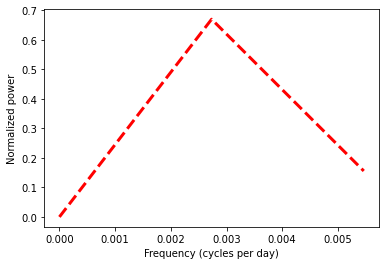

In [12]:
### Plot spectrum -- but only the first 3 harmonics (which includes the mean)
A = Ck2/np.sum(Ck2) ## normalized power
A[3::] = 0.
plt.plot(freq[0:3],A[0:3],'--r',linewidth = 3);
plt.ylabel('Normalized power');
plt.xlabel('Frequency (cycles per day)');

print(freq[0:3])
print('Separation between low and high frequency at:', 1/freq[2],' days')

In [25]:
### Apply a high-pass filter - remove the low frequencies
## remove the mean and the first two harmonics
Z3 = np.copy(Z)
Z3[0:3:] = 0.
#Z3[-2::] = 0.
X_hp = np.real(np.fft.ifft(Z3))

### Apply a low-pass filter - remove the high frequencies
### retain only the mean and the first two harmonics, set all other frequencies to zero
Z2 = np.copy(Z)
#Z2[3:-2:] = 0.0
Z2[0:-2:] = 0.0
X_smoothed = np.real(np.fft.ifft(Z2))

In [30]:
#plt.plot(np.real(Z3),color='red');
#plt.plot(np.real(Z2),color='black');
#print(Z3)
#print(Z2)

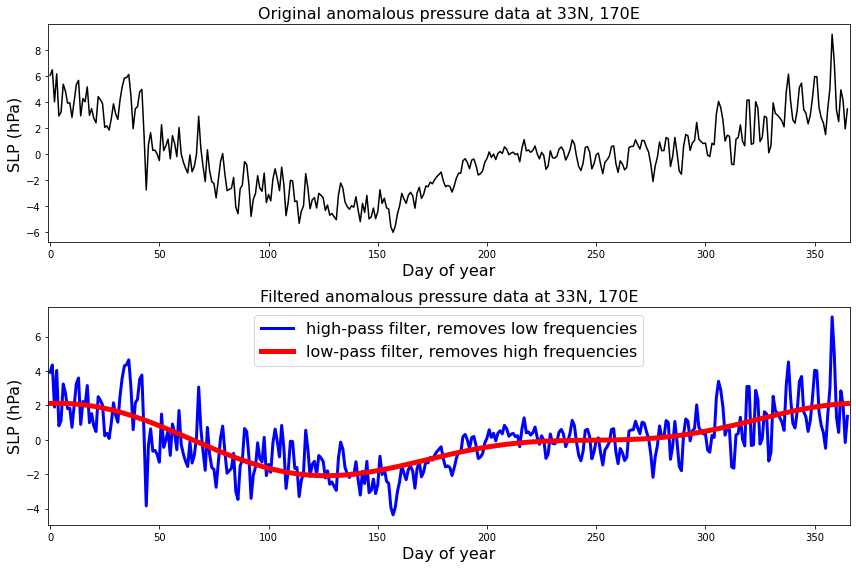

In [28]:
### Plot results
f=plt.figure(figsize=(12,8))
gs=GridSpec(2,1)
plt.subplot(gs[0,0])
plt.plot(np.arange(0,np.size(X)),X,'-k', label = 'data')
plt.ylabel('SLP (hPa)',fontsize=16)
plt.xlabel('Day of year',fontsize=16)
plt.xlim(-1,366)
plt.title('Original anomalous pressure data at 33N, 170E',fontsize=16)

plt.subplot(gs[1,0])
plt.plot(np.arange(0,np.size(X)),X_hp,'-b',linewidth = 3, label='high-pass filter, removes low frequencies')
plt.plot(np.arange(0,np.size(X)),X_smoothed,'-r',linewidth = 5, label ='low-pass filter, removes high frequencies')
plt.ylabel('SLP (hPa)',fontsize=16)
plt.xlabel('Day of year',fontsize=16)
plt.xlim(-1,366)
plt.title('Filtered anomalous pressure data at 33N, 170E',fontsize=16)
plt.legend(fontsize=16)

f.tight_layout()

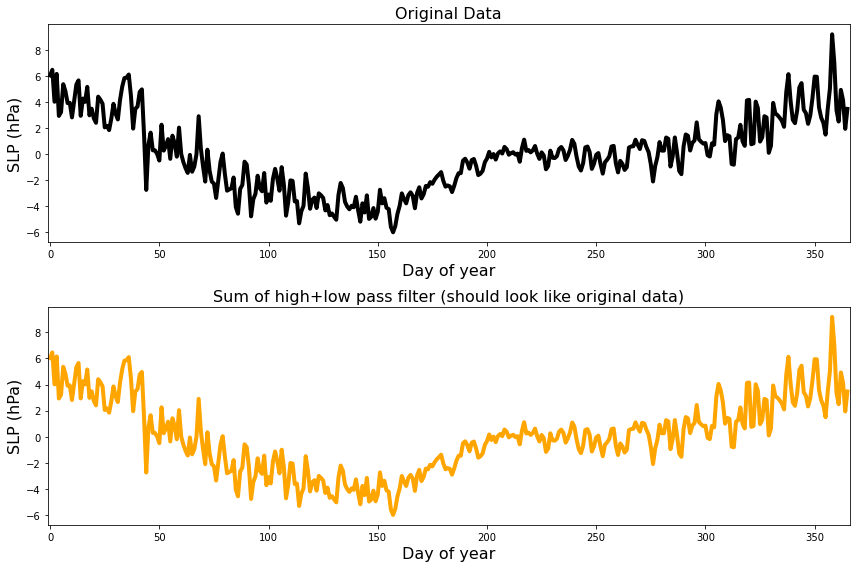

In [29]:
### Plot results
f=plt.figure(figsize=(12,8))
gs=GridSpec(2,1)
plt.subplot(gs[0,0])
plt.plot(np.arange(0,np.size(X)),X,'-k', label = 'Original Data',linewidth = 4)
plt.ylabel('SLP (hPa)',fontsize=16)
plt.xlabel('Day of year',fontsize=16)
plt.xlim(-1,366)
plt.title('Original Data',fontsize=16)

plt.subplot(gs[1,0])
# plot sum of low pass and high pass
plt.plot(np.arange(0,np.size(X)),X_smoothed+X_hp,'-',color = 'orange',linewidth = 4, label ='sum high+low filter');
plt.ylabel('SLP (hPa)',fontsize=16)
plt.xlabel('Day of year',fontsize=16)
plt.xlim(-1,366)
plt.title('Sum of high+low pass filter (should look like original data)',fontsize=16)

f.tight_layout()